# SOSE SALT BUDGET

In [1]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import intake
%matplotlib inline

/srv/conda/envs/notebook/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [52]:
from dask.distributed import Client

client = Client("tcp://10.32.60.88:35591")
client

Client Scheduler: tcp://10.32.60.88:35591 Dashboard: /user/0000-0002-8176-9465/proxy/8787/status,Cluster Workers: 3 Cores: 6 Memory: 34.50 GB


In [3]:
ocean_url = 'https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean.yaml'
ocean_cat = intake.Catalog(ocean_url)
ds = ocean_cat["SOSE"].to_dask()
ds

<xarray.Dataset>
Dimensions:   (XC: 2160, XG: 2160, YC: 320, YG: 320, Z: 42, Zl: 42, Zp1: 43, Zu: 42, time: 438)
Coordinates:
    Depth     (YC, XC) float32 dask.array<shape=(320, 2160), chunksize=(320, 2160)>
    PHrefC    (Z) float32 dask.array<shape=(42,), chunksize=(42,)>
    PHrefF    (Zp1) float32 dask.array<shape=(43,), chunksize=(43,)>
  * XC        (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * XG        (XG) float32 5.551115e-17 0.16666667 ... 359.6667 359.83334
  * YC        (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * YG        (YG) float32 -77.9583 -77.79163 -77.62497 ... -24.9583 -24.791632
  * Z         (Z) float32 -5.0 -15.5 -27.0 -39.5 ... -5075.0 -5325.0 -5575.0
  * Zl        (Zl) float32 0.0 -10.0 -21.0 -33.0 ... -4950.0 -5200.0 -5450.0
  * Zp1       (Zp1) float32 0.0 -10.0 -21.0 -33.0 ... -5200.0 -5450.0 -5700.0
  * Zu        (Zu) float32 -10.0 -21.0 -33.0 -46.0 ... -5200.0 -5450.0 -5700.0
    drC       (Zp1) float32 dask.ar

In [4]:
coords = ds.coords.to_dataset().reset_coords() #ds split into coords
dsr = ds.reset_coords(drop=True) #ds dropping coords so it just holds data variables
dsr

<xarray.Dataset>
Dimensions:   (XC: 2160, XG: 2160, YC: 320, YG: 320, Z: 42, Zl: 42, Zp1: 43, Zu: 42, time: 438)
Coordinates:
  * XC        (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * XG        (XG) float32 5.551115e-17 0.16666667 ... 359.6667 359.83334
  * YC        (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * YG        (YG) float32 -77.9583 -77.79163 -77.62497 ... -24.9583 -24.791632
  * Z         (Z) float32 -5.0 -15.5 -27.0 -39.5 ... -5075.0 -5325.0 -5575.0
  * Zl        (Zl) float32 0.0 -10.0 -21.0 -33.0 ... -4950.0 -5200.0 -5450.0
  * Zp1       (Zp1) float32 0.0 -10.0 -21.0 -33.0 ... -5200.0 -5450.0 -5700.0
  * Zu        (Zu) float32 -10.0 -21.0 -33.0 -46.0 ... -5200.0 -5450.0 -5700.0
  * time      (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
Data variables:
    ADVr_SLT  (time, Zl, YC, XC) float32 dask.array<shape=(438, 42, 320, 2160), chunksize=(1, 42, 320, 2160)>
    ADVr_TH   (time, Zl, YC, XC) float32 dask.array<shap

In [5]:
import xgcm
grid = xgcm.Grid(ds, periodic=('XC', 'YC'))
grid

<xgcm.Grid>
Y Axis (not periodic):
  * center   YC --> left
  * left     YG --> center
T Axis (not periodic):
  * center   time
X Axis (not periodic):
  * center   XC --> left
  * left     XG --> center
Z Axis (not periodic):
  * center   Z --> left
  * left     Zl --> center
  * outer    Zp1 --> center
  * right    Zu --> center

## Salt component of buoyancy budget integrated over Weddell Sea Region
Here, $\mathcal{V}$, represents the closed system of the Weddell Sea.

$$
\int_{R}{\frac{\partial{S}}{\partial{t}}}d\mathcal{V} = -\int_{NB}F^{S}_{adv,y}dA - \int_{NB} F^{S}_{diff,y}dA - \int_{surf}F^{S}_{surf}\vert_{z=0}dA
$$

Where 'NB' denotes northern boundary of region R, and 'surf' represents the boundary closed by the ocean surface. Both the first term and second term represents the the northern boundary crossing of the meridional advective flux and meridional diffusive flux, respectively; and the last term represents the surface flux crossing the ocean surface area.

## Salt Budget for Weddell Gyre

In [6]:
sss_mean = dsr.SALT.isel(Z=0).mean(dim='time').load()

In [7]:
surface_mask = (coords.hFacC[0]>0).load()

In [8]:
left_lon = 298
upper_lat = -65
right_lon = 360
lower_lat =-80

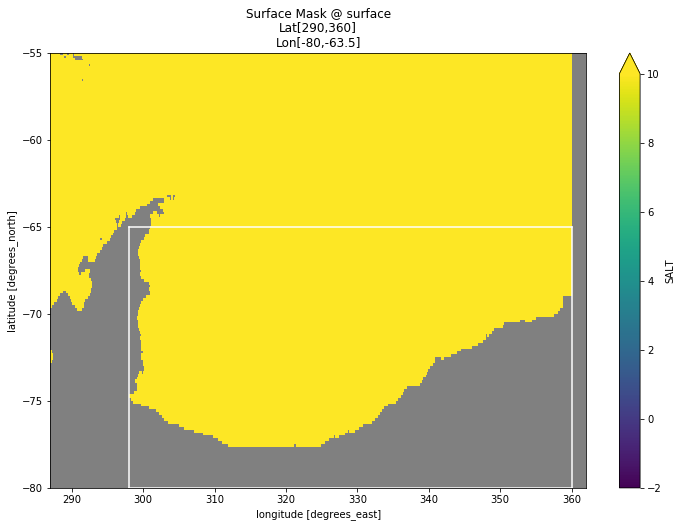

In [9]:
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'facecolor': '0.5'})
(sss_mean.where(surface_mask)).plot(ax=ax, vmin=-2, vmax=10)
ax.plot([left_lon, right_lon], [upper_lat, upper_lat], color='w')
ax.plot([right_lon, right_lon], [lower_lat, upper_lat], color='w')
ax.plot([left_lon, left_lon], [lower_lat, upper_lat], color='w')
ax.plot([left_lon, right_lon], [lower_lat, lower_lat], color='w')
#ax.patch(xy=(-80, 290), width=70, height=20)
#ax.patch(xy=(295,-80), width = 1, height = 1)
ax.set_xlim([287, 362])
ax.set_ylim([-80, -55])
plt.title('Surface Mask @ surface\nLat[290,360]\nLon[-80,-63.5]');

In [10]:
#set the boundaries
lat_range = dict(YC=slice(lower_lat, upper_lat))
lon_range = dict(XC=slice(left_lon, right_lon))

In [11]:
dsr.ADVy_SLT.sel(YG=upper_lat, method='nearest')

<xarray.DataArray 'ADVy_SLT' (time: 438, Z: 42, XC: 2160)>
dask.array<shape=(438, 42, 2160), dtype=float32, chunksize=(1, 42, 2160)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
    YG       float32 -64.9583
  * Z        (Z) float32 -5.0 -15.5 -27.0 -39.5 ... -5075.0 -5325.0 -5575.0
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
Attributes:
    long_name:      Meridional Advective Flux of Salinity
    mate:           ADVx_SLT
    standard_name:  ADVy_SLT
    units:          psu.m^3/s

In [41]:
#advective flux
adv_flux_y = dsr.ADVy_SLT.sel(**lon_range).sel(YG=upper_lat, method='nearest').sum(dim=['XC', 'Z']).load()
adv_flux_x = dsr.ADVx_SLT.sel(**lat_range).sel(XG=right_lon, method='nearest').sum(dim=['YC', 'Z']).load()
adv_flux = adv_flux_x + adv_flux_y
adv_flux.load()
#units: (psu m^3)/s

<xarray.DataArray (time: 438)>
array([ 2.120806e+08, -6.866362e+07, -4.182502e+07, ...,  2.144986e+07,
        1.619987e+07,  1.419917e+07], dtype=float32)
Coordinates:
    XG       float32 359.83334
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
    YG       float32 -64.9583

In [43]:
#should I add minus sign for the rhs terms if their values are positive, implying northward flow?
adv_flux_y

<xarray.DataArray 'ADVy_SLT' (time: 438)>
array([8.050039e+08, 7.692350e+08, 8.173951e+08, ..., 7.756420e+08,
       7.945360e+08, 9.015346e+08], dtype=float32)
Coordinates:
    YG       float32 -64.9583
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

In [17]:
#diffusive flux
diff_flux_y = dsr.DFyE_SLT.sel(**lon_range).sel(YG=upper_lat, method='nearest').sum(dim=['XC', 'Z']).load()
diff_flux_x = dsr.DFxE_SLT.sel(**lat_range).sel(XG=360, method='nearest').sum(dim=['YC', 'Z']).load()
diff_flux = diff_flux_x + diff_flux_y
diff_flux.load()
#units: (psu m^3)/s

<xarray.DataArray (time: 438)>
array([11442.695 , 13209.954 , 12736.924 , ...,  7871.5537,  9151.003 ,
        6265.8438], dtype=float32)
Coordinates:
    XG       float32 359.83334
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
    YG       float32 -64.9583

In [18]:
#vertical flux
s_flux_z = (dsr.SFLUX.sel(**lat_range, **lon_range) * coords.rA).sum(dim=['XC','YC'])
s_flux_z.load()
#units: (g/s)

<xarray.DataArray (time: 438)>
array([-1.508921e+10, -6.025603e+09, -3.707238e+09, ..., -6.714052e+09,
       -1.021455e+10, -9.395188e+09], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

In [25]:
coords.rA.sel(YC=-63.5, method='nearest')

<xarray.DataArray 'rA' (XC: 2160)>
dask.array<shape=(2160,), dtype=float32, chunksize=(2160,)>
Coordinates:
    YC       float32 -63.541634
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
Attributes:
    coordinate:     YC XC
    long_name:      cell area
    standard_name:  cell_area
    units:          m2

In [26]:
dsr.WSLTMASS.sel(YC=-63.4583, method='nearest')

<xarray.DataArray 'WSLTMASS' (time: 438, Zl: 42, XC: 2160)>
dask.array<shape=(438, 42, 2160), dtype=float32, chunksize=(1, 42, 2160)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
    YC       float32 -63.541634
  * Zl       (Zl) float32 0.0 -10.0 -21.0 -33.0 ... -4950.0 -5200.0 -5450.0
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
Attributes:
    long_name:      Vertical Mass-Weight Transp of Salinity
    standard_name:  WSLTMASS
    units:          psu.m/s

In [27]:
#linear free surface correction
runit2mass = 1.035e3 #kg/m^3
surface_term = s_flux_z / runit2mass
#units: (psu m^3)/s

lin_fs_correction = -(dsr.WSLTMASS.isel(Zl=0, drop=True) * coords.rA
                     ).sel(YC=slice(lower_lat, upper_lat)).sum(dim=['XC', 'YC'])
#lin_fs_correction longitude window is slightly different than other terms
#units: (psu m^3)/s

In [28]:
surface_term.load()
lin_fs_correction.load()

<xarray.DataArray (time: 438)>
array([ 8.113135e+08, -9.963056e+06, -2.871589e+07, ..., -3.794054e+07,
        6.848096e+07, -2.700906e+07], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

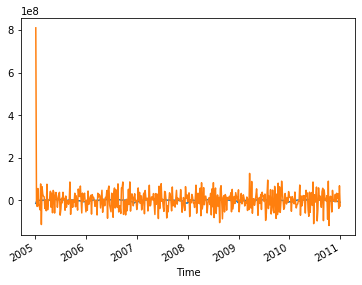

In [31]:
surface_term.plot()
lin_fs_correction.plot()

In [32]:
#is it hFacC or hFacS
total_volume = (coords.rA + coords.drF + coords.hFacC).sum().load()
total_volume

<xarray.DataArray ()>
array(6.010579e+15, dtype=float32)

In [33]:
#units say psu/day but the time stamps are for every 5 days, so does that mean psu/5days?
dsr.TOTSTEND.sel(YC=upper_lat, method='nearest')

<xarray.DataArray 'TOTSTEND' (time: 438, Z: 42, XC: 2160)>
dask.array<shape=(438, 42, 2160), dtype=float32, chunksize=(1, 42, 2160)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
    YC       float32 -65.04163
  * Z        (Z) float32 -5.0 -15.5 -27.0 -39.5 ... -5075.0 -5325.0 -5575.0
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
Attributes:
    long_name:      Tendency of Salinity
    standard_name:  TOTSTEND
    units:          psu/day

In [35]:
tot_s_tend_weddell = (dsr.TOTSTEND * coords.rA * coords.drF * coords.hFacC
          ).sel(**lon_range, YC=slice(lower_lat, upper_lat)).sum(dim=['XC', 'YC', 'Z']) / (24*60*60)
tot_s_tend_weddell.load()
#same longitudinal window as lin_fs_correction (63.541634)
#units: (psu m^2)/day

<xarray.DataArray (time: 438)>
array([-21856965.973333,   -914069.997037,  -3340300.894815, ...,
        -5373661.487407,  -9690647.514074,  -9571545.694815])
Coordinates:
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

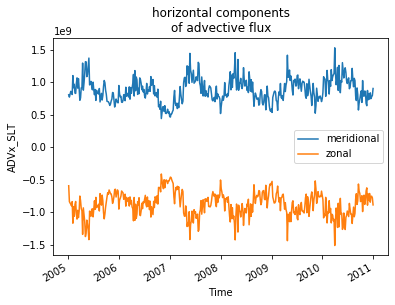

In [44]:
adv_flux_y.plot(label='meridional')
adv_flux_x.plot(label='zonal')
plt.legend()
plt.title('horizontal components\nof advective flux');

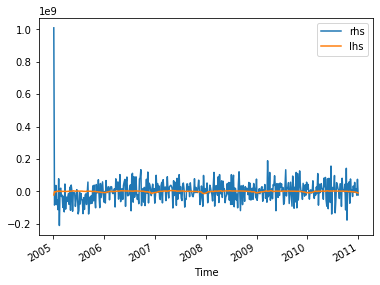

In [47]:
rhs = + adv_flux + diff_flux + lin_fs_correction + surface_term
lhs = tot_s_tend_weddell
rhs.plot(label='rhs')
lhs.plot(label='lhs')
plt.legend();

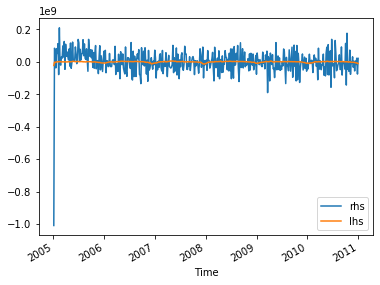

In [50]:
rhs = - adv_flux - diff_flux - lin_fs_correction - surface_term
lhs = tot_s_tend_weddell
rhs.plot(label='rhs')
lhs.plot(label='lhs')
plt.legend();

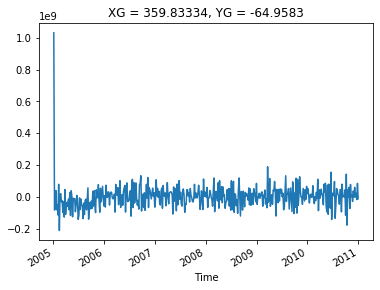

In [48]:
(rhs - lhs).plot()

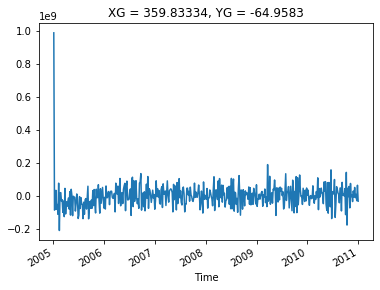

In [49]:
(rhs + lhs).plot()

In [51]:
(rhs - lhs).mean().load()

<xarray.DataArray ()>
array(-1123007.284904)
Coordinates:
    XG       float32 359.83334
    YG       float32 -64.9583

In [53]:
all_terms = xr.merge([tot_s_tend_weddell.rename('totstend'),
                      adv_flux.rename('adv_flux'),
                      diff_flux.rename('diff_flux'),
                      lin_fs_correction.rename('lin_fs'),
                      surface_term.rename('surface')])
all_terms

<xarray.Dataset>
Dimensions:    (time: 438)
Coordinates:
  * time       (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
    XG         float32 359.83334
    YG         float32 -64.9583
Data variables:
    totstend   (time) float64 -2.186e+07 -9.141e+05 ... -9.691e+06 -9.572e+06
    adv_flux   (time) float32 212080640.0 -68663620.0 ... 16199872.0 14199168.0
    diff_flux  (time) float32 11442.695 13209.954 ... 9151.003 6265.8438
    lin_fs     (time) float32 811313500.0 -9963056.0 ... 68480960.0 -27009058.0
    surface    (time) float32 -14578951.0 -5821838.5 ... -9869132.0 -9077476.0

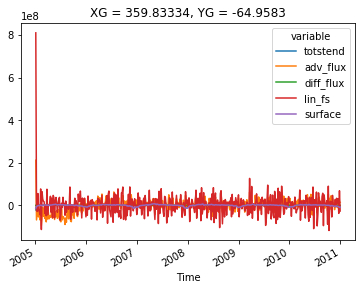

In [54]:
all_terms.to_array().plot.line(x='time')

In [55]:
df = all_terms.mean(dim='time').reset_coords(drop=True).to_array().to_dataframe(name='budget')
df

,budget
variable,
totstend,-8.905917e+04
adv_flux,-4.921784e+05
diff_flux,7.013557e+03
lin_fs,1.802272e+06
surface,-1.050406e+05


In [56]:
rhs_minus_lhs = df.iloc[0] - df.iloc[1:].sum()
rhs_minus_lhs

budget   -1.301126e+06
dtype: float64

In [57]:
budget_diff = rhs.sum() + lhs.sum()
budget_diff.load()

<xarray.DataArray ()>
array(-5.698929e+08)
Coordinates:
    XG       float32 359.83334
    YG       float32 -64.9583

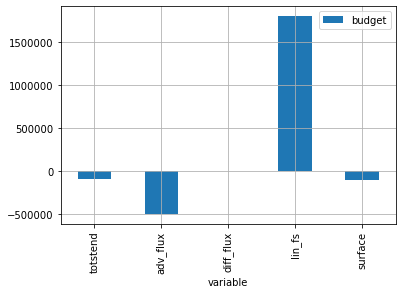

In [59]:
df.plot(kind='bar')
plt.grid();

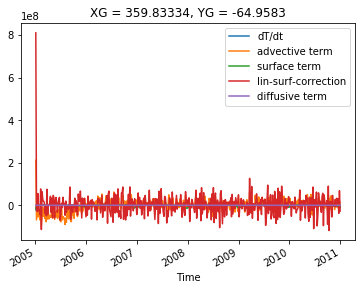

In [60]:
tot_s_tend_weddell.plot(label='dT/dt')
adv_flux.plot(label='advective term')
surface_term.plot(label='surface term')
lin_fs_correction.plot(label='lin-surf-correction')
diff_flux.plot(label='diffusive term')
plt.legend();

(200000000.0, -200000000.0)

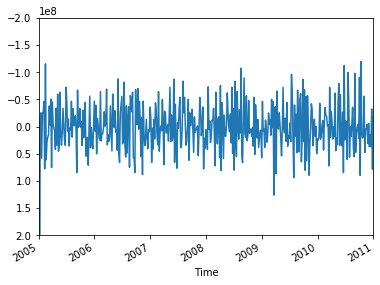

In [68]:
(lin_fs_correction - tot_s_tend_weddell).plot()
plt.xlim('2005', '2011')
plt.ylim(2e8, -2e8)